### Detection Transformer (DeTR)

![../assets/detr.png](../assets/detr.png)

The model architecture of DETR begins with a CNN backbone, similar to other image-based networks, the output of which is processed and fed into a transformer encoder, resulting in N embeddings. The encoder embeddings are added to learned positional embeddings (called object queries) and used in a transformer decoder, generating another N embeddings. As a final step, each of the N embeddings are put through individual feed forward layers to predict the width, height, coordinates of the bounding box, as well as the object class (or whether there is an object).

![../assets/conditional_detr.png](../assets/conditional_detr.png)

Detected cat with confidence 0.998 at location [344.06, 24.85, 640.34, 373.74]
Detected remote with confidence 0.997 at location [328.13, 75.93, 372.81, 187.66]
Detected remote with confidence 0.997 at location [39.34, 70.13, 175.56, 118.78]
Detected cat with confidence 0.998 at location [15.36, 51.75, 316.89, 471.16]
Detected couch with confidence 0.995 at location [-0.19, 0.71, 639.73, 474.17]


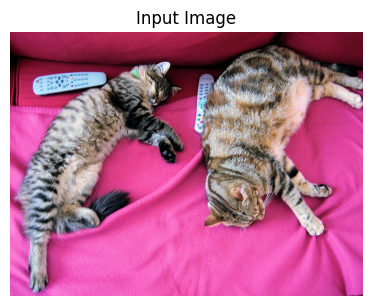

In [2]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image, ImageDraw
import requests
import matplotlib.pyplot as plt
import numpy as np
import json

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis('off')

# initialize the model
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-101", revision="no_timm"
)
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-101", revision="no_timm"
)

# preprocess the inputs and infer
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# non max supression above 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.9
)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )



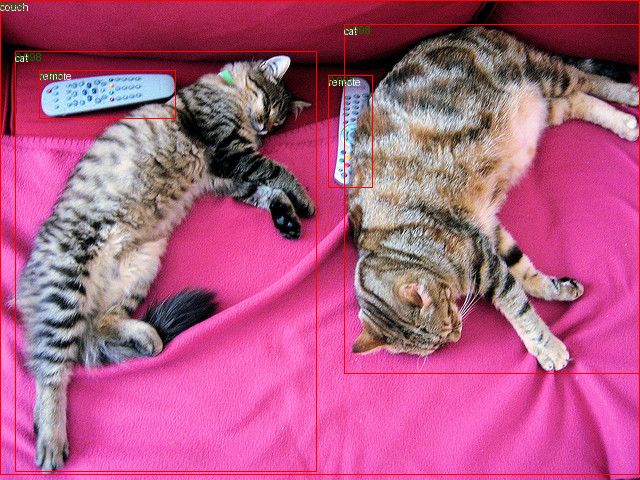

In [8]:
def plot_results(image, results, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        score = round(score.item(), 3)
        label = model.config.id2label[label.item()]
        box = [round(i, 2) for i in box.tolist()]
        if score > threshold:
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=1)
            draw.text((x, y), label, fill="white")
            draw.text(
                (x + 0.5, y - 0.5),
                text=str(score),
                fill="green" if score > 0.7 else "red",
            )
    return image

plot_results(image, results, threshold=0.7)

In [9]:
import torch
from torch import nn
from torchvision.models import resnet50


class DETR(nn.Module):
    def __init__(
        self, num_classes, hidden_dim, nheads, num_encoder_layers, num_decoder_layers
    ):
        super().__init__()
        self.backbone = nn.Sequential(*list(resnet50(pretrained=True).children())[:-2])
        self.conv = nn.Conv2d(2048, hidden_dim, 1)
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers
        )
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        x = self.backbone(inputs)
        h = self.conv(x)
        H, W = h.shape[-2:]
        pos = (
            torch.cat(
                [
                    self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
                    self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
                ],
                dim=-1,
            )
            .flatten(0, 1)
            .unsqueeze(1)
        )
        h = self.transformer(
            pos + h.flatten(2).permute(2, 0, 1), self.query_pos.unsqueeze(1)
        )
        return self.linear_class(h), self.linear_bbox(h).sigmoid()